#  GAN Data Augmentation (COCO Format)


**Key Features:**
- Uses balanced annotations (`Annotations/train_zipfian_object_balanced.coco.json`) - Zipfian balanced on images
- Downloads images from Roboflow
- Trains conditional DCGAN on dice crops
- Generates full scene images with dice placed on backgrounds

## 1. Setup & Installation

In [8]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install roboflow pillow matplotlib seaborn tqdm numpy

Looking in indexes: https://download.pytorch.org/whl/cu118


In [9]:
# Clone the git repository with the code
import os
if not os.path.exists('Dice-Detection'):
    !git clone https://github.com/Adr44mo/Dice-Detection.git
    %cd Dice-Detection
else:
    %cd Dice-Detection

# Add src to path
import sys
sys.path.append('./src')

Cloning into 'Dice-Detection'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 84 (delta 41), reused 67 (delta 24), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 2.47 MiB | 32.03 MiB/s, done.
Resolving deltas: 100% (41/41), done.
/content/Dice-Detection/Dice-Detection


## 2. Import Libraries

In [10]:
import json
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Import custom modules from src
from src.gan import (
    Generator,
    Discriminator,
    weights_init,
    generate_dice_image,
    extract_backgrounds,
    create_synthetic_coco_dataset
)
from src.dataset import DiceDetectionDataset  # For verification

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 3. Download Dataset from Roboflow

In [11]:
from roboflow import Roboflow

rf = Roboflow(api_key="kd9lS9tvh5StEQtSA6i9")
project = rf.workspace("workspace-spezm").project("dice-0sexk")
dataset = project.version(2).download("coco")
print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dice-2 in coco:: 100%|██████████| 1467/1467 [00:00<00:00, 4005.28it/s]

Dataset downloaded to: /content/Dice-Detection/Dice-Detection/dice-2


## 4. Load Balanced Annotations

In [27]:
# Load balanced annotations from local file
ANNOTATION_FILE_train = 'Annotations/train_zipfian_object_balanced.coco.json'
ANNOTATION_FILE_val = 'Annotations/val_zipfian_object_balanced.coco.json'

IMAGE_BASE_PATH_train = f'{dataset.location}/train'
IMAGE_BASE_PATH_val = f'{dataset.location}/valid'

with open(ANNOTATION_FILE_train, 'r') as f:
    balanced_annotations_train = json.load(f)

with open(ANNOTATION_FILE_val, 'r') as f:
    balanced_annotations_val = json.load(f)

print(f"Loaded balanced annotations from: {ANNOTATION_FILE_train}")
print(f"Images: {len(balanced_annotations_train['images'])}")
print(f"Annotations: {len(balanced_annotations_train['annotations'])}")
print(f"Categories: {len(balanced_annotations_train['categories'])}")

# Extract categories (only numeric dice classes)
categories_train = {cat['id']: cat['name'] for cat in balanced_annotations_train['categories']}
valid_categories_train = {k: v for k, v in categories_train.items() if v.isdigit()}
print(f"\nValid dice categories: {valid_categories_train}")

# Create image lookup
image_id_to_info_train = {
    img['id']: {'file_name': img['file_name'], 'width': img['width'], 'height': img['height']}
    for img in balanced_annotations_train['images']
}

print(f"Loaded balanced annotations from: {ANNOTATION_FILE_val}")
print(f"Images: {len(balanced_annotations_val['images'])}")
print(f"Annotations: {len(balanced_annotations_val['annotations'])}")
print(f"Categories: {len(balanced_annotations_val['categories'])}")

categories_val = {cat['id']: cat['name'] for cat in balanced_annotations_val['categories']}
valid_categories_val = {k: v for k, v in categories_val.items() if v.isdigit()}
print(f"\nValid dice categories: {valid_categories_val}")

image_id_to_info_val = {
    img['id']: {'file_name': img['file_name'], 'width': img['width'], 'height': img['height']}
    for img in balanced_annotations_val['images']
}

Loaded balanced annotations from: Annotations/train_zipfian_object_balanced.coco.json
Images: 481
Annotations: 1219
Categories: 7

Valid dice categories: {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'}
Loaded balanced annotations from: Annotations/val_zipfian_object_balanced.coco.json
Images: 85
Annotations: 255
Categories: 7

Valid dice categories: {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'}


## 5. Extract Dice Crops

Crop dice from downloaded images using bounding boxes from balanced annotations.

In [28]:
IMG_SIZE = 64
OUTPUT_DIR_TRAIN = 'gan_training_data'
OUTPUT_DIR_VAL = 'gan_validation_data'

os.makedirs(OUTPUT_DIR_TRAIN, exist_ok=True)
for cat_name in valid_categories_train.values():
    os.makedirs(os.path.join(OUTPUT_DIR_TRAIN, cat_name), exist_ok=True)

os.makedirs(OUTPUT_DIR_VAL, exist_ok=True)
for cat_name in valid_categories_val.values():
    os.makedirs(os.path.join(OUTPUT_DIR_VAL, cat_name), exist_ok=True)

class_counts_train = Counter()

print("\nCropping dice images from balanced training dataset...")

for ann in tqdm(balanced_annotations_train['annotations']):
    category_id = ann['category_id']
    if category_id not in valid_categories_train:
        continue

    image_id = ann['image_id']
    bbox = ann['bbox']
    category_name = valid_categories_train[category_id]
    image_info = image_id_to_info_train.get(image_id)

    if not image_info:
        continue

    image_path = os.path.join(IMAGE_BASE_PATH_train, image_info['file_name'])

    try:
        img = Image.open(image_path).convert('RGB')
        x_min, y_min, width, height = [int(b) for b in bbox]
        x_max, y_max = x_min + width, y_min + height
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(img.width, x_max), min(img.height, y_max)

        cropped = img.crop((x_min, y_min, x_max, y_max))
        resized = cropped.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)

        output_filename = f"{image_id}_{ann['id']}.png"
        output_path = os.path.join(OUTPUT_DIR_TRAIN, category_name, output_filename)
        resized.save(output_path)
        class_counts_train[category_name] += 1
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

print("\n✅ Cropping complete for training dataset!")
for cat in sorted(class_counts_train.keys()):
    print(f"  Class {cat}: {class_counts_train[cat]} images")


class_counts_val = Counter()

print("\nCropping dice images from balanced validation dataset...")

for ann in tqdm(balanced_annotations_val['annotations']):
    category_id = ann['category_id']
    if category_id not in valid_categories_val:
        continue

    image_id = ann['image_id']
    bbox = ann['bbox']
    category_name = valid_categories_val[category_id]
    image_info = image_id_to_info_val.get(image_id)

    if not image_info:
        continue

    image_path = os.path.join(IMAGE_BASE_PATH_val, image_info['file_name'])

    try:
        img = Image.open(image_path).convert('RGB')
        x_min, y_min, width, height = [int(b) for b in bbox]
        x_max, y_max = x_min + width, y_min + height
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(img.width, x_max), min(img.height, y_max)

        cropped = img.crop((x_min, y_min, x_max, y_max))
        resized = cropped.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)

        output_filename = f"{image_id}_{ann['id']}.png"
        output_path = os.path.join(OUTPUT_DIR_VAL, category_name, output_filename)
        resized.save(output_path)
        class_counts_val[category_name] += 1
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

print("\n✅ Cropping complete for validation dataset!")
for cat in sorted(class_counts_val.keys()):
    print(f"  Class {cat}: {class_counts_val[cat]} images")


Cropping dice images from balanced training dataset...


100%|██████████| 1219/1219 [00:04<00:00, 294.95it/s]



✅ Cropping complete for training dataset!
  Class 1: 109 images
  Class 2: 109 images
  Class 3: 182 images
  Class 4: 182 images
  Class 5: 212 images
  Class 6: 425 images

Cropping dice images from balanced validation dataset...


100%|██████████| 255/255 [00:00<00:00, 288.33it/s]


✅ Cropping complete for validation dataset!
  Class 1: 28 images
  Class 2: 28 images
  Class 3: 57 images
  Class 4: 57 images
  Class 5: 28 images
  Class 6: 57 images


## 6. GAN Architecture & Hyperparameters

In [29]:
# Hyperparameters
LATENT_DIM = 100
NUM_CLASSES = 6
EMBED_DIM = 50
NGF = 64
NDF = 64
NC = 3
BATCH_SIZE = 32
NUM_EPOCHS = 500
LR = 0.0002
BETA1 = 0.5

print(f"Latent dimension: {LATENT_DIM}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of epochs: {NUM_EPOCHS}")
print(f"Learning rate: {LR}")

Latent dimension: 100
Number of classes: 6
Batch size: 32
Number of epochs: 500
Learning rate: 0.0002


In [30]:
# Initialize models from src.gan
netG = Generator(LATENT_DIM, NUM_CLASSES, EMBED_DIM, NGF, NC).to(device)
netD = Discriminator(NUM_CLASSES, NDF, NC, IMG_SIZE).to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)

print(f"Generator params: {sum(p.numel() for p in netG.parameters()):,}")
print(f"Discriminator params: {sum(p.numel() for p in netD.parameters()):,}")

Generator params: 3,986,604
Discriminator params: 2,791,168


## 7. Prepare Dataset & DataLoader

In [31]:
class DiceDataset(Dataset):
    """Dataset for loading cropped dice images for GAN training."""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for label_idx, label_name in enumerate(['1', '2', '3', '4', '5', '6']):
            label_dir = os.path.join(root_dir, label_name)
            if os.path.exists(label_dir):
                for img_name in os.listdir(label_dir):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((os.path.join(label_dir, img_name), label_idx))
        print(f"Loaded {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transforms
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dice_dataset = DiceDataset(OUTPUT_DIR_TRAIN, transform=transform)
dataloader = DataLoader(dice_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

print(f"Number of batches: {len(dataloader)}")

Loaded 1219 samples
Number of batches: 38


## 8. Training

In [32]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

G_losses, D_losses = [], []

print("Starting Training...")
for epoch in range(NUM_EPOCHS):
    epoch_D_loss, epoch_G_loss = 0, 0

    for real_imgs, labels in dataloader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        real_label = torch.ones(batch_size, device=device) * 0.9
        fake_label = torch.zeros(batch_size, device=device) + 0.1

        # Train Discriminator
        netD.zero_grad()
        output_real = netD(real_imgs, labels)
        # Workaround: Reshape output from [batch_size * 25] to [batch_size, 25] and take mean
        output_real_reshaped = output_real.reshape(batch_size, -1).mean(dim=1)
        errD_real = criterion(output_real_reshaped, real_label)
        errD_real.backward()

        noise = torch.randn(batch_size, LATENT_DIM, device=device)
        fake_imgs = netG(noise, labels)
        output_fake = netD(fake_imgs.detach(), labels)
        # Workaround: Reshape output from [batch_size * 25] to [batch_size, 25] and take mean
        output_fake_reshaped = output_fake.reshape(batch_size, -1).mean(dim=1)
        errD_fake = criterion(output_fake_reshaped, fake_label)
        errD_fake.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        output = netD(fake_imgs, labels)
        # Workaround: Reshape output from [batch_size * 25] to [batch_size, 25] and take mean
        output_reshaped = output.reshape(batch_size, -1).mean(dim=1)
        errG = criterion(output_reshaped, real_label)
        errG.backward()
        optimizerG.step()

        epoch_D_loss += (errD_real + errD_fake).item()
        epoch_G_loss += errG.item()

    G_losses.append(epoch_G_loss / len(dataloader))
    D_losses.append(epoch_D_loss / len(dataloader))

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"[{epoch+1:3d}/{NUM_EPOCHS}] Loss_D: {D_losses[-1]:.4f} | Loss_G: {G_losses[-1]:.4f}")

print("\n✅ Training complete!")

Starting Training...
[  1/500] Loss_D: 1.5044 | Loss_G: 4.2477
[ 20/500] Loss_D: 0.9204 | Loss_G: 2.4605
[ 40/500] Loss_D: 0.8661 | Loss_G: 2.4411
[ 60/500] Loss_D: 0.8370 | Loss_G: 2.4036
[ 80/500] Loss_D: 0.7844 | Loss_G: 2.2569
[100/500] Loss_D: 0.7715 | Loss_G: 2.2842
[120/500] Loss_D: 0.7700 | Loss_G: 2.2524
[140/500] Loss_D: 0.7413 | Loss_G: 2.3653
[160/500] Loss_D: 0.7638 | Loss_G: 2.3854
[180/500] Loss_D: 0.7186 | Loss_G: 2.2799
[200/500] Loss_D: 0.7634 | Loss_G: 2.3716
[220/500] Loss_D: 0.7291 | Loss_G: 2.3073
[240/500] Loss_D: 0.7019 | Loss_G: 2.1909
[260/500] Loss_D: 0.7466 | Loss_G: 2.3725
[280/500] Loss_D: 0.7285 | Loss_G: 2.3410
[300/500] Loss_D: 0.7308 | Loss_G: 2.3265
[320/500] Loss_D: 0.8097 | Loss_G: 2.3241
[340/500] Loss_D: 0.7112 | Loss_G: 2.1900
[360/500] Loss_D: 0.7217 | Loss_G: 2.1864
[380/500] Loss_D: 0.7272 | Loss_G: 2.2261
[400/500] Loss_D: 0.7154 | Loss_G: 2.2769
[420/500] Loss_D: 0.7127 | Loss_G: 2.2689
[440/500] Loss_D: 0.7035 | Loss_G: 2.1857
[460/500] Los

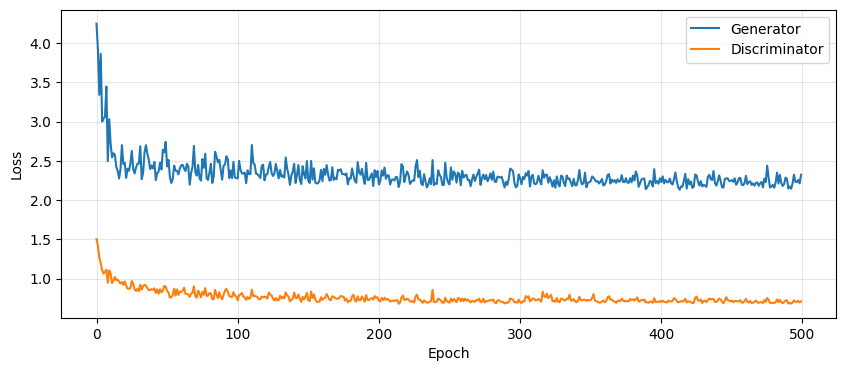

In [33]:
# Plot training losses
plt.figure(figsize=(10, 4))
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('training_losses.png', dpi=150)
plt.show()

## 9. Generate COCO-Format Dataset

Create full scene images with dice on backgrounds and COCO annotations using functions from `src.gan`.

In [34]:
# Extract background images from downloaded dataset
BACKGROUND_DIR = 'backgrounds'
train_images_dir = f'{dataset.location}/train'
val_images_dir = f'{dataset.location}/valid'

print("Extracting background samples from training images...")
bg_count = extract_backgrounds(train_images_dir, BACKGROUND_DIR, num_backgrounds=50)
print(f"Extracted {bg_count} background images")

print("Extracting background samples from validation images...")
bg_count = extract_backgrounds(val_images_dir, BACKGROUND_DIR, num_backgrounds=50)
print(f"Extracted {bg_count} background images")

Extracting background samples from training images...
Extracted 50 background images
Extracting background samples from validation images...
Extracted 50 background images


In [36]:
# Configuration for synthetic dataset generation
SYNTHETIC_COCO_DIR = 'synthetic_coco_dataset'

# Calculate images needed per class for balancing in training set
current_counts_train = {str(i): class_counts_train.get(str(i), 0) for i in range(1, 7)}
target_count_train = max(current_counts_train.values())
images_to_generate_train = {k: max(0, target_count_train - v) for k, v in current_counts_train.items()}

print(f"Current class distribution: {current_counts_train}")
print(f"Target count per class: {target_count_train}")

# We'll add synthetic dice to existing images to avoid overlap issues
num_images_to_augment_train = len(balanced_annotations_train['images']) // 2  # Augment half of the images
print(f"Will add synthetic dice to {num_images_to_augment_train} existing images")

# Generation config - ADD synthetic dice to existing images
gen_config = {
    'scene_size': (640, 640),
    'dice_size_range': (60, 120),
    'dice_per_image': (1, 3),  # Add 1-3 dice per image
    'num_images': num_images_to_augment_train,
    'merge_with_original': True,  # Merge with original annotations
    'add_to_existing_images': True  # Add to existing images instead of creating new ones
}

# Generate augmented COCO dataset (merges with original)
coco_data_train = create_synthetic_coco_dataset(
    generator=netG,
    background_dir=BACKGROUND_DIR,
    output_dir=os.path.join(SYNTHETIC_COCO_DIR, 'train'), # Specify train subdirectory
    config=gen_config,
    device=device,
    class_counts=current_counts_train,
    latent_dim=LATENT_DIM,
    original_annotations=balanced_annotations_train,  # Pass original annotations
    original_image_dir=IMAGE_BASE_PATH_train  # Pass original image directory
)


# calculate images needed per class for balancing in validation set
current_counts_val = {str(i): class_counts_val.get(str(i), 0) for i in range(1, 7)}
target_count_val = max(current_counts_val.values())
images_to_generate_val = {k: max(0, target_count_val - v) for k, v in current_counts_val.items()}

print(f"Current class distribution: {current_counts_val}")
print(f"Target count per class: {target_count_val}")

# We'll add synthetic dice to existing images to avoid overlap issues
num_images_to_augment_val = len(balanced_annotations_val['images']) // 2  # Augment half of the images
print(f"Will add synthetic dice to {num_images_to_augment_val} existing images")

# Generation config - ADD synthetic dice to existing images
gen_config_val = {
    'scene_size': (640, 640),
    'dice_size_range': (60, 120),
    'dice_per_image': (1, 3),  # Add 1-3 dice per image
    'num_images': num_images_to_augment_val,
    'merge_with_original': True,  # Merge with original annotations
    'add_to_existing_images': True  # Add to existing images instead of creating new ones
}

# Generate augmented COCO dataset (merges with original)
coco_data_val = create_synthetic_coco_dataset(
    generator=netG,
    background_dir=BACKGROUND_DIR,
    output_dir=os.path.join(SYNTHETIC_COCO_DIR, 'val'), # Specify val subdirectory
    config=gen_config_val,
    device=device,
    class_counts=current_counts_val,
    latent_dim=LATENT_DIM,
    original_annotations=balanced_annotations_val,  # Pass original annotations
    original_image_dir=IMAGE_BASE_PATH_val  # Pass original image directory
)

# For visualization, let's use the train coco data, or you might want to visualize both.
coco_data = coco_data_train # Or pick coco_data_val if you want to visualize validation.

Current class distribution: {'1': 109, '2': 109, '3': 182, '4': 182, '5': 212, '6': 425}
Target count per class: 425
Will add synthetic dice to 240 existing images
Merging with original annotations...
Starting from image_id=1226, annotation_id=2788
Generating 240 synthetic scenes...
Adding synthetic dice to existing images...


100%|██████████| 240/240 [00:02<00:00, 104.82it/s]



✅ Generated dataset with 481 total images and 1699 total annotations
   Annotations saved to: synthetic_coco_dataset/train/annotations/train.coco.json

Synthetic dice added per class:
  Class 1: 88 dice
  Class 2: 94 dice
  Class 3: 105 dice
  Class 4: 100 dice
  Class 5: 93 dice
  Class 6: 0 dice
Current class distribution: {'1': 28, '2': 28, '3': 57, '4': 57, '5': 28, '6': 57}
Target count per class: 57
Will add synthetic dice to 42 existing images
Merging with original annotations...
Starting from image_id=127, annotation_id=381
Generating 42 synthetic scenes...
Adding synthetic dice to existing images...


100%|██████████| 42/42 [00:00<00:00, 141.04it/s]



✅ Generated dataset with 85 total images and 337 total annotations
   Annotations saved to: synthetic_coco_dataset/val/annotations/train.coco.json

Synthetic dice added per class:
  Class 1: 30 dice
  Class 2: 23 dice
  Class 3: 0 dice
  Class 4: 0 dice
  Class 5: 29 dice
  Class 6: 0 dice


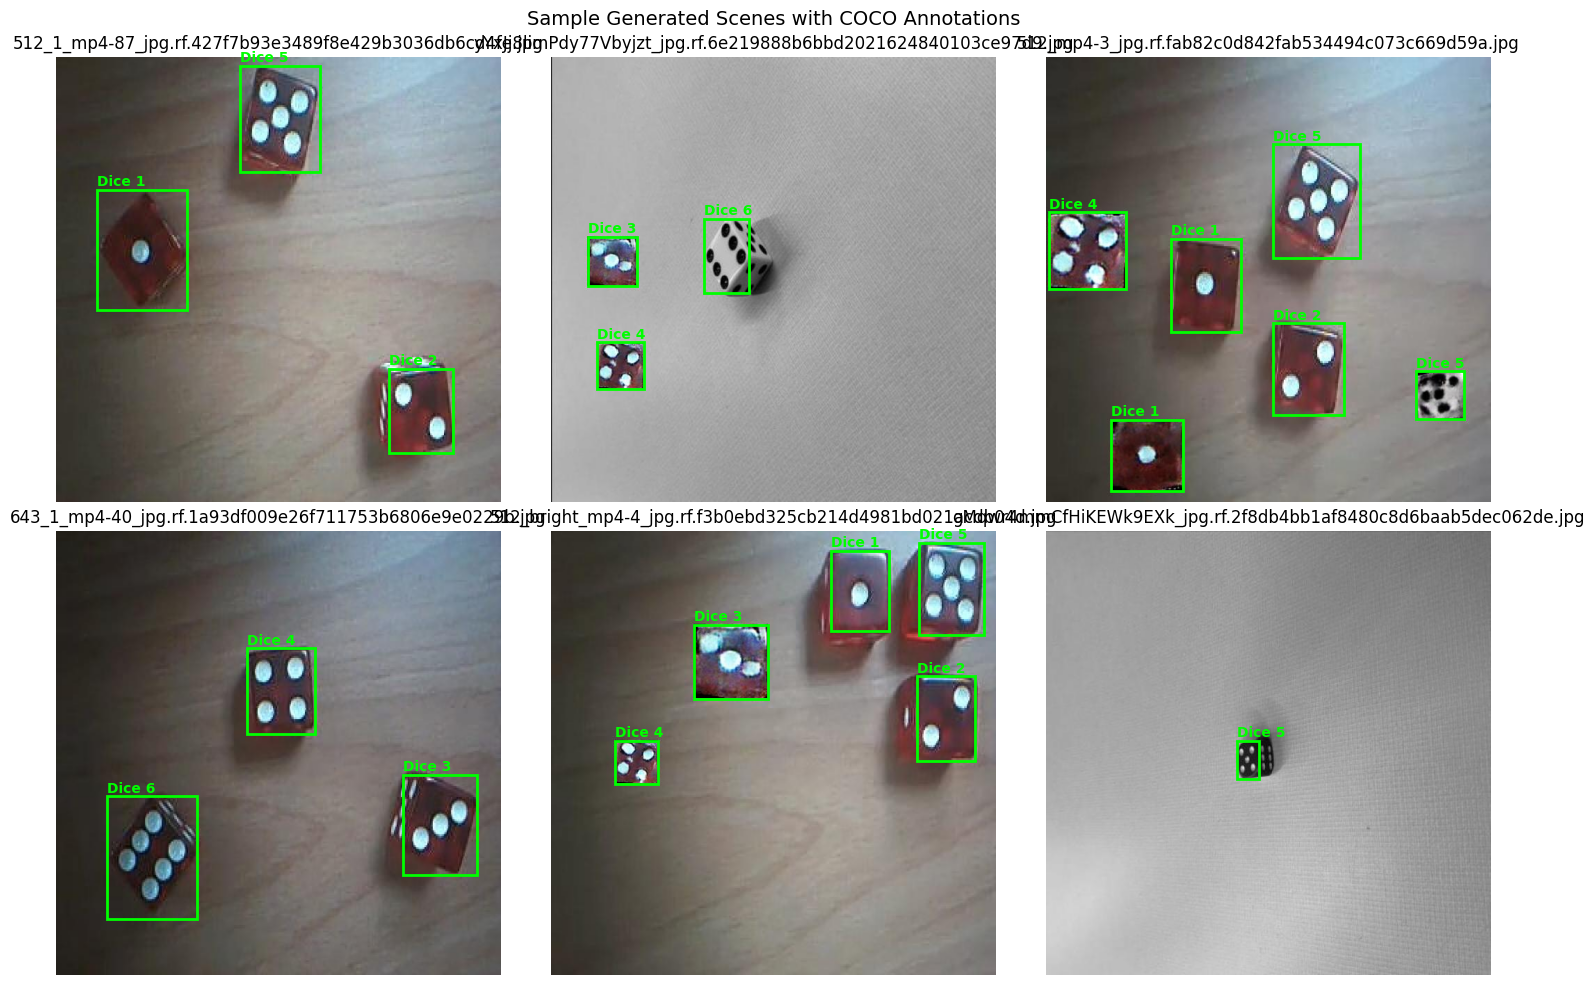

In [45]:
# Visualize sample generated scenes
import matplotlib.patches as patches

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

sample_images = random.sample(coco_data['images'], min(6, len(coco_data['images'])))

for ax, img_info in zip(axes, sample_images):
    # Corrected path to point to the nested 'train' folder within the synthetic dataset
    img_path = os.path.join(SYNTHETIC_COCO_DIR, 'train', 'train', img_info['file_name'])
    img = Image.open(img_path)
    ax.imshow(img)

    # Draw bounding boxes
    for ann in coco_data['annotations']:
        if ann['image_id'] == img_info['id']:
            x, y, w, h = ann['bbox']
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 5, f"Dice {ann['category_id']}", color='lime', fontsize=10, weight='bold')

    ax.axis('off')
    ax.set_title(img_info['file_name'])

plt.suptitle('Sample Generated Scenes with COCO Annotations', fontsize=14)
plt.tight_layout()
plt.savefig('sample_coco_scenes.png', dpi=150)
plt.show()

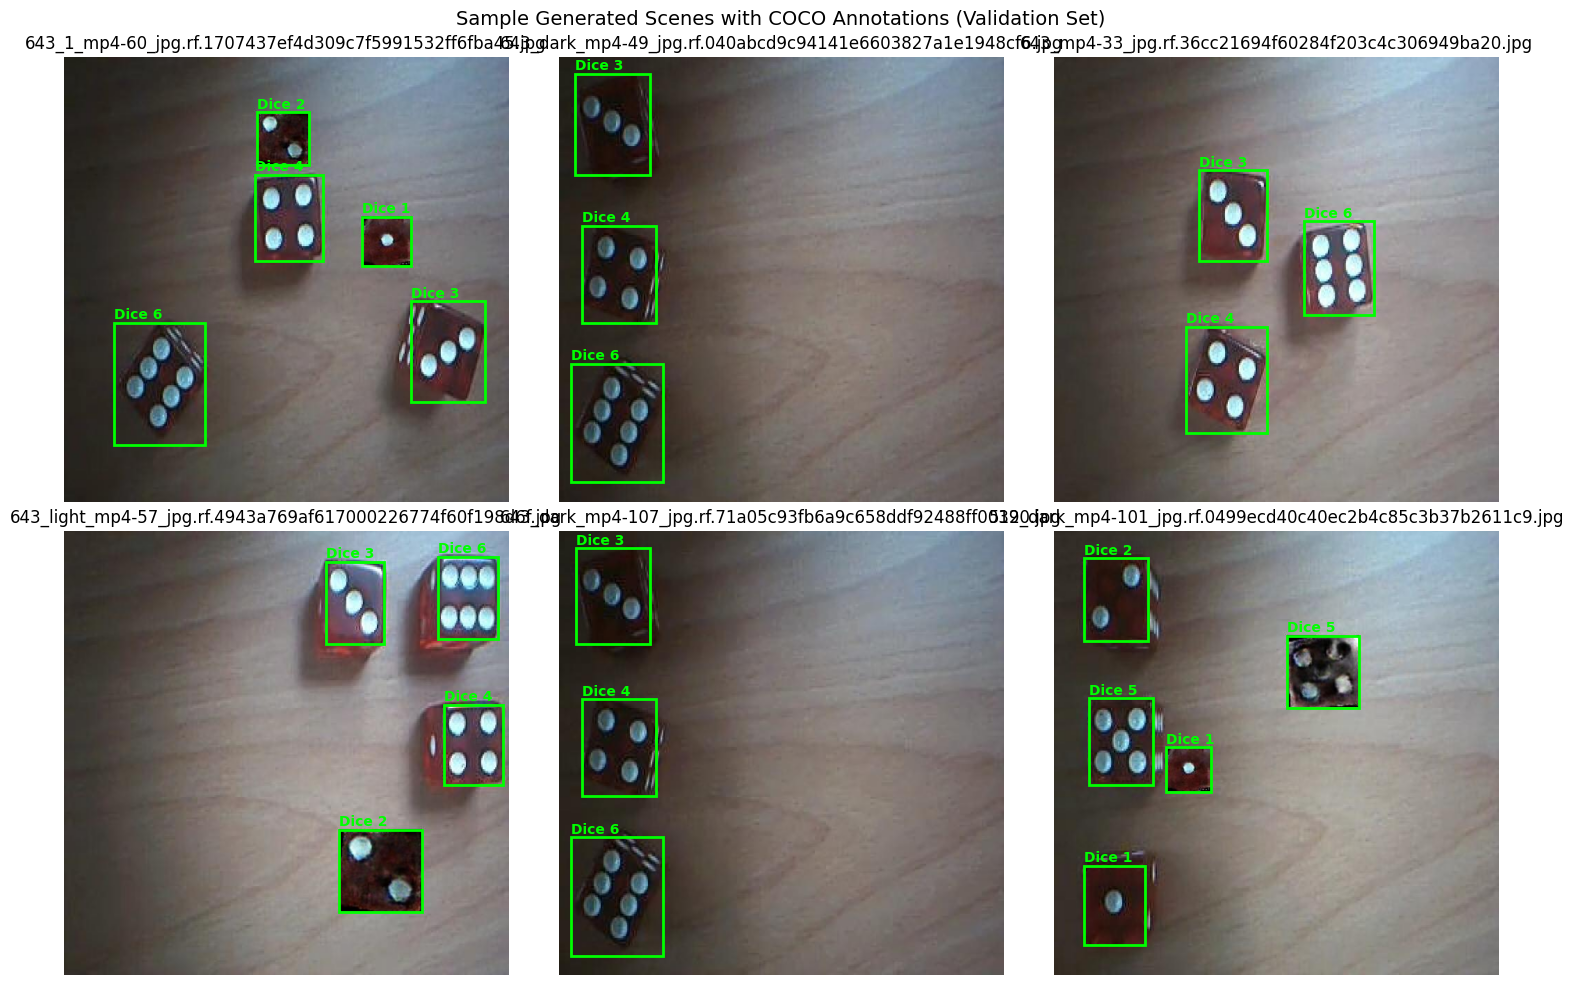

In [49]:
# visualize synthetic dice for validation
import matplotlib.patches as patches

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

sample_images_val = random.sample(coco_data_val['images'], min(6, len(coco_data_val['images'])))

for ax, img_info in zip(axes, sample_images_val):
    # Corrected path to point to the nested 'val' folder within the synthetic dataset
    img_path = os.path.join(SYNTHETIC_COCO_DIR, 'val', 'train', img_info['file_name'])
    img = Image.open(img_path)
    ax.imshow(img)

    # Draw bounding boxes
    for ann in coco_data_val['annotations']:
        if ann['image_id'] == img_info['id']:
            x, y, w, h = ann['bbox']
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 5, f"Dice {ann['category_id']}", color='lime', fontsize=10, weight='bold')

    ax.axis('off')
    ax.set_title(img_info['file_name'])

plt.suptitle('Sample Generated Scenes with COCO Annotations (Validation Set)', fontsize=14)
plt.tight_layout()
plt.savefig('sample_coco_scenes_val.png', dpi=150)
plt.show()

## 10. Save Model

In [ ]:
MODEL_DIR = 'gan_models'
os.makedirs(MODEL_DIR, exist_ok=True)

torch.save({
    'generator_state_dict': netG.state_dict(),
    'discriminator_state_dict': netD.state_dict(),
    'epoch': NUM_EPOCHS,
    'G_losses': G_losses,
    'D_losses': D_losses,
}, os.path.join(MODEL_DIR, 'conditional_dcgan_dice.pth'))

print(f"✅ Model saved to {MODEL_DIR}/conditional_dcgan_dice.pth")

✅ Model saved to gan_models/conditional_dcgan_dice.pth
